In [141]:
from astropy.io import ascii
from astropy.io import fits
from astropy.table import Table, Column, join, hstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.visualization import ZScaleInterval

import numpy as np
from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt
import astropy.cosmology
import matplotlib as mpl
from matplotlib import pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
from lmfit.models import GaussianModel, LinearModel

# Enable inline plotting in this notebook
%matplotlib inline

pathtodata = '../data/'
pathtospectra = '/misc/marenostrum/pgperez/gbarro/DEIMOS/halo7d/data_reduction_HY_V2/'

import warnings
warnings.filterwarnings('ignore')

In [183]:
data=Table.read('../data/SIP_egs_spec_candels_data.hdf5')
data

HALO7D_ID,obs_date [16],obs_date.mask [16],mask_folder [16],mask_folder.mask [16],mask [16],mask.mask [16],slit [16],slit.mask [16],num_obs [1],num_obs.mask [1],zbest,zbest.mask,M_2a_tau,M_2a_tau.mask,M_14a_tau,M_14a_tau.mask,ir_SFRTOTf,ir_SFRTOTf.mask,WFC3_F160W_flux,WFC3_F160W_flux.mask
bytes13,bytes13,bool,bytes11,bool,bytes11,bool,int64,bool,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool
10051,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0 .. 0,True .. True,8,True,0.01,False,9.58,False,-99.0,False,0.0337953,False,585.94377,False
10234,2014apr06 ..,False .. False,E1a ..,False .. False,E1a ..,False .. False,0 .. 0,False .. False,8,False,0.035,False,6.85,False,-99.0,False,0.0274546,False,3.06730675,False
10272,2014apr06 ..,False .. False,E1a ..,False .. False,E1a ..,False .. False,1 .. 0,False .. False,8,False,0.03,False,7.94,False,-99.0,False,0.0597286,False,16.8442875,False
10274,2016apr09 ..,False .. False,E5a ..,False .. False,E5a ..,False .. False,4 .. 0,False .. False,5,False,0.134,False,9.51,False,7.39361,False,0.036039,False,1.82754524,False
10381,2014apr06 ..,False .. False,E1a ..,False .. False,E1a ..,False .. False,2 .. 0,False .. False,8,False,1.962,False,7.42,False,8.27854,False,6.27293,False,1.07857201,False
10406,2014apr29 ..,False .. False,E0c ..,False .. False,E0c ..,False .. False,14 .. 0,False .. False,5,False,0.03,False,7.47,False,-99.0,False,0.000591279,False,8.48216118,False
10423,2014apr29 ..,False .. False,E0c ..,False .. False,E0c ..,False .. False,93 .. 0,False .. False,5,False,0.739,False,9.68,False,9.56411,False,9.28227,False,7.80953724,False
10588,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0 .. 0,True .. True,8,True,0.005,False,10.34,False,-99.0,False,0.0157657,False,11940.2515,False
10635,2016apr09 ..,False .. False,E5a ..,False .. False,E5a ..,False .. False,5 .. 0,False .. False,5,False,0.015,False,8.89,False,-99.0,False,0.0787542,False,53.5181665,False


In [184]:
data['HALO7D_ID'] = data['HALO7D_ID'].astype(str)
data['obs_date'] = data['obs_date'].astype(str)
data['mask'] = data['mask'].astype(str)
data['mask_folder'] = data['mask_folder'].astype(str)
C = {'egs' : data}

In [185]:
def abmag(flux): 
    return -2.5*np.log10(flux)+23.9
def log10n(x):
    logx=np.choose(x>0.,(-99.,np.log10(x)))
    return logx

In [186]:
selection = (data['zbest'] > 0.6)\
& (data['zbest'] < 0.8)\
& (data['HALO7D_ID'] != '-999')\
& (data['M_2a_tau'] > 9)\
& (data['M_2a_tau'] < 10)\
& (log10n(data['ir_SFRTOTf'])>data['M_14a_tau']-9.5)\
& (data['M_14a_tau']>=9.5)\
& (abmag(data['WFC3_F160W_flux'])<24)

In [187]:
data['HALO7D_ID','zbest'][selection]

HALO7D_ID,zbest
str13,float64
10423,0.739
26165,0.738
7175,0.6469
irac102206,0.746
irac119139,0.714
irac119158,0.724
irac123233,0.734
irac129931,0.759


In [188]:
h7_data=data["HALO7D_ID", "zbest"][selection]
h7_data

HALO7D_ID,zbest
str13,float64
10423,0.739
26165,0.738
7175,0.6469
irac102206,0.746
irac119139,0.714
irac119158,0.724
irac123233,0.734
irac129931,0.759


In [189]:
zspec=[0.749, 0,0,0.780,0.769,0.756,0.765,0.758]
h7_data["zspec"]=zspec
h7_data

HALO7D_ID,zbest,zspec
str13,float64,float64
10423,0.739,0.749
26165,0.738,0.0
7175,0.6469,0.0
irac102206,0.746,0.78
irac119139,0.714,0.769
irac119158,0.724,0.756
irac123233,0.734,0.765
irac129931,0.759,0.758


In [190]:
data_new=astropy.table.join(data, h7_data, keys="HALO7D_ID", join_type='outer')
data_new

HALO7D_ID,obs_date [16],obs_date.mask [16],mask_folder [16],mask_folder.mask [16],mask [16],mask.mask [16],slit [16],slit.mask [16],num_obs [1],num_obs.mask [1],zbest_1,zbest.mask,M_2a_tau,M_2a_tau.mask,M_14a_tau,M_14a_tau.mask,ir_SFRTOTf,ir_SFRTOTf.mask,WFC3_F160W_flux,WFC3_F160W_flux.mask,zbest_2,zspec
str13,str13,bool,str11,bool,str11,bool,int64,bool,int64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,bool,float64,float64
10051,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0 .. 0,True .. True,8,True,0.01,False,9.58,False,-99.0,False,0.0337953,False,585.94377,False,--,--
10234,2014apr06 ..,False .. False,E1a ..,False .. False,E1a ..,False .. False,0 .. 0,False .. False,8,False,0.035,False,6.85,False,-99.0,False,0.0274546,False,3.06730675,False,--,--
10272,2014apr06 ..,False .. False,E1a ..,False .. False,E1a ..,False .. False,1 .. 0,False .. False,8,False,0.03,False,7.94,False,-99.0,False,0.0597286,False,16.8442875,False,--,--
10274,2016apr09 ..,False .. False,E5a ..,False .. False,E5a ..,False .. False,4 .. 0,False .. False,5,False,0.134,False,9.51,False,7.39361,False,0.036039,False,1.82754524,False,--,--
10381,2014apr06 ..,False .. False,E1a ..,False .. False,E1a ..,False .. False,2 .. 0,False .. False,8,False,1.962,False,7.42,False,8.27854,False,6.27293,False,1.07857201,False,--,--
10406,2014apr29 ..,False .. False,E0c ..,False .. False,E0c ..,False .. False,14 .. 0,False .. False,5,False,0.03,False,7.47,False,-99.0,False,0.000591279,False,8.48216118,False,--,--
10423,2014apr29 ..,False .. False,E0c ..,False .. False,E0c ..,False .. False,93 .. 0,False .. False,5,False,0.739,False,9.68,False,9.56411,False,9.28227,False,7.80953724,False,0.739,0.749
10588,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0.0 .. 0.0,True .. True,0 .. 0,True .. True,8,True,0.005,False,10.34,False,-99.0,False,0.0157657,False,11940.2515,False,--,--
10635,2016apr09 ..,False .. False,E5a ..,False .. False,E5a ..,False .. False,5 .. 0,False .. False,5,False,0.015,False,8.89,False,-99.0,False,0.0787542,False,53.5181665,False,--,--


In [197]:
sp = np.flatnonzero(data['HALO7D_ID'] == 'irac102206')[0] # Picking out the index of target galaxy in data table
print(data['obs_date'][sp]) # Show all observing runs for this object
print(data['mask'][sp]) # Show all corresponding masks for this object
run = 1 # Picking which of the runs to plot

['2015mar25' '2015apr12' '2015mar24' '2015apr13' '2015may18' '2015may19'
 '' '' '' '' '' '' '' '' '' '']
['E4a' 'E4b' 'E4a' 'E4b' 'E4a' 'E4a' '' '' '' '' '' '' '' '' '' '']


In [198]:
hdu = fits.open(pathtospectra + data['obs_date'][sp][run] + '_red/' + data['mask_folder'][sp][run]\
               + '/spec1d.' + data['mask'][sp][run] + '.' + str('%03i'%data['slit'][sp][run]) + '.' +
               data['HALO7D_ID'][sp] + '.fits')
#/misc/marenostrum/pgperez/gbarro/DEIMOS/halo7d/data_reduction_HY_V2/2016mar03_red/c3a/spec1d.c3a.082.serendip2.fits',

Text(0, 0.5, 'Flux')

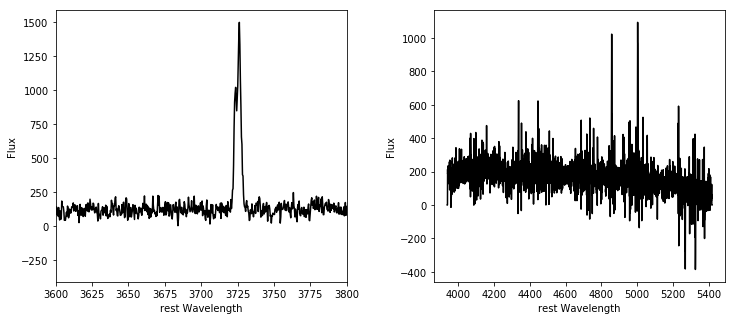

In [201]:
blue = hdu[1].data[0]
red = hdu[2].data[0]
f, ax = plt.subplots(1, 2, figsize = [12,5])
f.subplots_adjust(wspace = 0.3)

# Blue Side
ax[0].plot(blue['LAMBDA']/(1 + data_new['zspec'][sp]), blue['SPEC'], 'k-')
# Around OII
ax[0].set_xlim(3600,3800)
ax[0].set_xlabel('rest Wavelength')
ax[0].set_ylabel('Flux')

# Red Side
ax[1].plot(red['LAMBDA']/(1 + data_new['zspec'][sp]),red['SPEC'],'k-')
# Around OIII
#ax[1].set_xlim(8700,8900)
ax[1].set_xlabel('rest Wavelength')
ax[1].set_ylabel('Flux')

In [211]:
def gaussian(x, amp, mu, sigma):
    return (amp / (sqrt(2*pi) * sigma)) * exp(-(x - mu)**2 / (2*sigma**2))

def index_of(arrval, value):
    if value < min(arrval):
        return 0 
    return max(np.where(arrval <= value)[0])

In [212]:
emline1 = GaussianModel()
bck1 = LinearModel()
emline2 = GaussianModel()
bck2 = LinearModel()
emline3 = GaussianModel()
bck3 = LinearModel()

In [246]:
linepars1 = bck1.make_params(intercept = blue['SPEC'].mean(), slope = 0)
linepars2 = bck2.make_params(intercept = red['SPEC'].mean(), slope = 0)
linepars3 = bck3.make_params(intercept = red['SPEC'].mean(), slope = 0)

lside1 = index_of(blue['LAMBDA']/(1+data_new["zspec"][sp]), 3600)
rside1 = index_of(blue['LAMBDA']/(1+data_new["zspec"][sp]), 3800)
linepars1 += emline1.guess(blue['SPEC'][lside1:rside1], x = (blue['LAMBDA']/(1+data_new["zspec"][sp]))[lside1:rside1])
lside2 = index_of(red['LAMBDA'], 8725)
rside2 = index_of(red['LAMBDA'], 8800)
linepars2 += emline2.guess(red['SPEC'][lside2:rside2], x = red['LAMBDA'][lside2:rside2])
lside3 = index_of(red['LAMBDA'], 8825)
rside3 = index_of(red['LAMBDA'], 8875)
linepars3 += emline3.guess(red['SPEC'][lside3:rside3], x = red['LAMBDA'][lside3:rside3])

In [247]:
linemodel1 = emline1 + bck1
fitline1 = linemodel1.fit(blue['SPEC'], linepars1, x = blue['LAMBDA']/(1+data_new["zspec"][sp]))
linemodel2 = emline2 + bck2
fitline2 = linemodel2.fit(red['SPEC'], linepars2, x = red['LAMBDA'])
linemodel3 = emline3 + bck3
fitline3 = linemodel3.fit(red['SPEC'], linepars3, x = red['LAMBDA'])

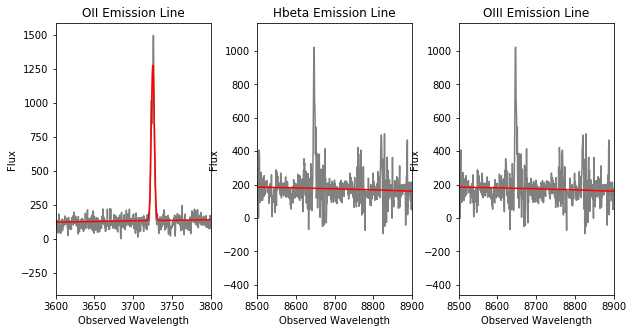

In [248]:
f,ax=plt.subplots(1,3,figsize=[10,5])
f.subplots_adjust(wspace=0.3)

#blue side
ax[0].plot(blue['LAMBDA']/(1+data_new["zspec"][sp]), blue['SPEC'], color = 'grey')
ax[0].plot(blue['LAMBDA']/(1+data_new["zspec"][sp]), fitline1.best_fit, 'r-')
ax[0].set_xlim(3600, 3800)
ax[0].set_xlabel('Observed Wavelength')
ax[0].set_ylabel('Flux')
ax[0].title.set_text('OII Emission Line')

#red side - Hbeta
ax[1].plot(red['LAMBDA'], red['SPEC'], color = 'grey')
ax[1].plot(red['LAMBDA'], fitline2.best_fit, 'r-')
ax[1].set_xlim(8500, 8900)
ax[1].set_xlabel('Observed Wavelength')
ax[1].set_ylabel('Flux')
ax[1].title.set_text('Hbeta Emission Line')

#red  side - OIII
ax[2].plot(red['LAMBDA'], red['SPEC'], color = 'grey')
ax[2].plot(red['LAMBDA'], fitline3.best_fit, 'r-')
ax[2].set_xlim(8500, 8900)
ax[2].set_xlabel('Observed Wavelength')
ax[2].set_ylabel('Flux')
ax[2].title.set_text('OIII Emission Line')

In [249]:
fitline1

In [156]:
fitline2

In [157]:
fitline3

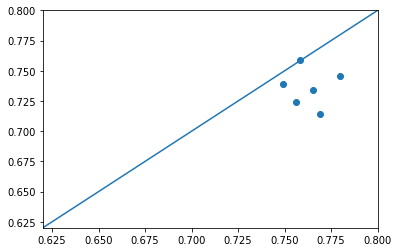

In [261]:
plt.scatter(data_new["zspec"][selection], data_new["zbest_1"][selection])
plt.xlim(0.62,0.80)
plt.ylim(0.62,0.80)
x=np.linspace(-5,5,100)
y=x
plt.plot(x,y)
plt.savefig('SIP_EGS_zzplot.png', path = pathtodata + 'SIP_EGS_zzplot.png')